# NYC Real Estate Uncertainty Estimator

Automated estimator that outputs **Aleatoric** (data noise) and **Epistemic** (model doubt) uncertainty for NYC property prices, with LLM-based feature engineering and SHAP interpretability.

## Phase 1 — Live Data Ingestion

Load NYC Citywide Rolling Calendar Sales CSV, clean SALE PRICE, square footage, derive building age, drop duplicates.

In [228]:
import os
import json
import random
import numpy as np
import pandas as pd
if os.environ.get("CI"):
    import matplotlib
    matplotlib.use("Agg")
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

In [229]:
df_raw = "NYC_Citywide_Rolling_Calendar_Sales.csv"
df_raw = pd.read_csv(df_raw)
df_raw.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,376,43,NaN,S1,743 EAST 6 STREET,NaN,...,1.0,1.0,2.0,"2,090",3680.0,1940.0,1,S1,0,01/23/2025
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372,9,NaN,C7,272 EAST 3 STREET,NaN,...,8.0,1.0,9.0,"2,021",7129.0,1900.0,2,C7,0,12/15/2025
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372,19,NaN,C7,"292 EAST 3 STREET, 4B",NaN,...,9.0,1.0,10.0,"2,401",6920.0,1920.0,2,C7,0,02/07/2025
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,41,NaN,C4,"745 EAST 6TH STREET, 1B",NaN,...,28.0,0.0,28.0,"4,542",18254.0,1900.0,2,C4,540000,12/17/2025
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,385,38,NaN,C4,"21-23 AVENUE C, 5B",NaN,...,20.0,2.0,22.0,"3,315",17160.0,1900.0,2,C4,0,11/11/2025


In [230]:
# removing unnecessary columns
df_raw.drop(['ADDRESS','EASE-MENT','APARTMENT NUMBER','SALE DATE','NEIGHBORHOOD','BUILDING CLASS AT PRESENT','BUILDING CLASS AT TIME OF SALE'],inplace=True, axis=1)
df_raw.head()

,BOROUGH,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
0,1,01 ONE FAMILY DWELLINGS,1,376,43,10009.0,1.0,1.0,2.0,"2,090",3680.0,1940.0,1,0
1,1,07 RENTALS - WALKUP APARTMENTS,2B,372,9,10009.0,8.0,1.0,9.0,"2,021",7129.0,1900.0,2,0
2,1,07 RENTALS - WALKUP APARTMENTS,2B,372,19,10009.0,9.0,1.0,10.0,"2,401",6920.0,1920.0,2,0
3,1,07 RENTALS - WALKUP APARTMENTS,2,376,41,10009.0,28.0,0.0,28.0,"4,542",18254.0,1900.0,2,540000
4,1,07 RENTALS - WALKUP APARTMENTS,2,385,38,10009.0,20.0,2.0,22.0,"3,315",17160.0,1900.0,2,0


In [231]:
def clean_numeric(ser, remove_commas=True):
    """Coerce to numeric, handling commas and empty strings."""
    if remove_commas:
        ser = ser.astype(str).str.replace(",", "", regex=False)
    return pd.to_numeric(ser, errors="coerce")

# Clean SALE PRICE: strip $/commas, cast to float
df = df_raw.copy()
df["SALE PRICE"] = clean_numeric(df["SALE PRICE"])
df = df[df["SALE PRICE"] > 0].copy()  # Drop $0 sales (transfers)

# Clean GROSS SQUARE FEET and LAND SQUARE FEET
df["GROSS SQUARE FEET"] = clean_numeric(df["GROSS SQUARE FEET"])
df["LAND SQUARE FEET"] = clean_numeric(df["LAND SQUARE FEET"])
df = df[(df["GROSS SQUARE FEET"] > 0) & (df["LAND SQUARE FEET"] > 0)].copy()

# Derive BUILDING AGE
df["YEAR BUILT"] = pd.to_numeric(df["YEAR BUILT"], errors="coerce")
df = df[df["YEAR BUILT"].between(1800, 2025)].copy()
df["BUILDING_AGE"] = 2025 - df["YEAR BUILT"]

# Drop duplicates
df = df.drop_duplicates(keep=False)

print(f"After cleaning: {len(df):,} rows")
print(df.head())

After cleaning: 22,865 rows
    BOROUGH         BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  BLOCK  LOT  \
3         1  07 RENTALS - WALKUP APARTMENTS                    2    376   41   
7         1  07 RENTALS - WALKUP APARTMENTS                    2    400   11   
8         1  07 RENTALS - WALKUP APARTMENTS                    2    400   54   
9         1  07 RENTALS - WALKUP APARTMENTS                   2B    402   36   
11        1  07 RENTALS - WALKUP APARTMENTS                   2B    404   42   

    ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  \
3    10009.0               28.0               0.0         28.0   
7    10009.0               18.0               0.0         18.0   
8    10009.0                8.0               3.0         11.0   
9    10009.0                8.0               2.0         10.0   
11   10009.0               10.0               0.0         10.0   

    LAND SQUARE FEET  GROSS SQUARE FEET  YEAR BUILT  \
3             4542.0            18254.0

In [232]:
df.duplicated(keep=False).sum()

np.int64(0)

In [233]:
df.isnull().sum()

,0
BOROUGH,0
BUILDING CLASS CATEGORY,0
TAX CLASS AT PRESENT,0
BLOCK,0
LOT,0
ZIP CODE,0
RESIDENTIAL UNITS,0
COMMERCIAL UNITS,0
TOTAL UNITS,0
LAND SQUARE FEET,0


In [234]:
df.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,BUILDING_AGE
count,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,2.286500e+04,2.286500e+04,22865.000000,22865.000000,2.286500e+04,22865.000000
mean,3.504352,5429.720883,63.796851,11002.736147,3.694686,0.305095,3.999781,4.159713e+03,5.565283e+03,1941.307282,1.266696,2.230256e+06,83.692718
std,1.023470,3741.286149,147.706753,473.926860,21.310015,4.132714,21.781460,5.202859e+04,3.316691e+04,30.810332,0.733689,1.593708e+07,30.810332
min,1.000000,8.000000,1.000000,10001.000000,0.000000,0.000000,0.000000,2.970000e+02,2.000000e+02,1800.000000,1.000000,1.000000e+00,0.000000
25%,3.000000,2467.000000,19.000000,10463.000000,1.000000,0.000000,1.000000,2.000000e+03,1.408000e+03,1920.000000,1.000000,6.750000e+05,65.000000
50%,4.000000,4899.000000,38.000000,11221.000000,2.000000,0.000000,2.000000,2.500000e+03,2.000000e+03,1931.000000,1.000000,9.300000e+05,94.000000
75%,4.000000,7646.000000,64.000000,11370.000000,2.000000,0.000000,2.000000,4.000000e+03,2.880000e+03,1960.000000,1.000000,1.410000e+06,105.000000
max,5.000000,16319.000000,8005.000000,11694.000000,602.000000,472.000000,606.000000,7.446955e+06,1.545708e+06,2025.000000,4.000000,1.080000e+09,225.000000


In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22865 entries, 3 to 79334
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BOROUGH                    22865 non-null  int64  
 1   BUILDING CLASS CATEGORY    22865 non-null  object 
 2   TAX CLASS AT PRESENT       22865 non-null  object 
 3   BLOCK                      22865 non-null  int64  
 4   LOT                        22865 non-null  int64  
 5   ZIP CODE                   22865 non-null  float64
 6   RESIDENTIAL UNITS          22865 non-null  float64
 7   COMMERCIAL UNITS           22865 non-null  float64
 8   TOTAL UNITS                22865 non-null  float64
 9   LAND SQUARE FEET           22865 non-null  float64
 10  GROSS SQUARE FEET          22865 non-null  float64
 11  YEAR BUILT                 22865 non-null  float64
 12  TAX CLASS AT TIME OF SALE  22865 non-null  int64  
 13  SALE PRICE                 22865 non-null  int64  


In [236]:
df.nunique()

,0
BOROUGH,5
BUILDING CLASS CATEGORY,23
TAX CLASS AT PRESENT,6
BLOCK,9234
LOT,629
ZIP CODE,176
RESIDENTIAL UNITS,122
COMMERCIAL UNITS,50
TOTAL UNITS,132
LAND SQUARE FEET,4137


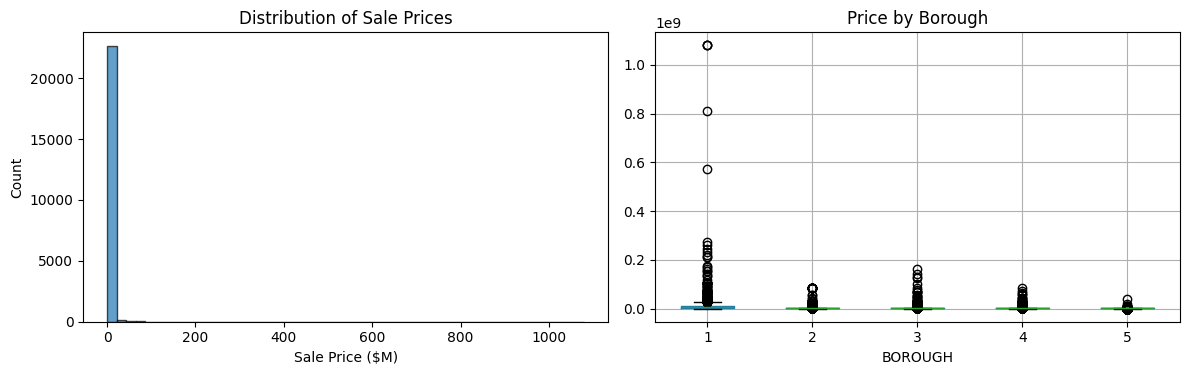

In [237]:
#Price distribution (histogram + boxplot)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df["SALE PRICE"] / 1e6, bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Sale Price ($M)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Sale Prices")
df.boxplot(column="SALE PRICE", by="BOROUGH", ax=axes[1])
axes[1].set_title("Price by Borough")
plt.suptitle("")
plt.tight_layout()
plt.show()

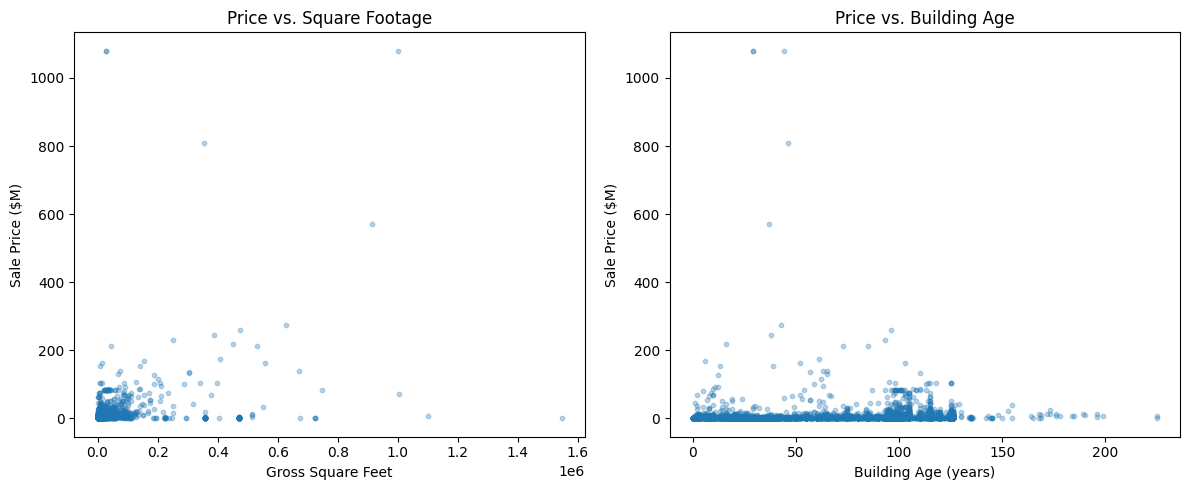

In [238]:
# Price vs. key features (scatter)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(df["GROSS SQUARE FEET"], df["SALE PRICE"] / 1e6, alpha=0.3, s=10)
axes[0].set_xlabel("Gross Square Feet")
axes[0].set_ylabel("Sale Price ($M)")
axes[0].set_title("Price vs. Square Footage")
axes[1].scatter(df["BUILDING_AGE"], df["SALE PRICE"] / 1e6, alpha=0.3, s=10)
axes[1].set_xlabel("Building Age (years)")
axes[1].set_ylabel("Sale Price ($M)")
axes[1].set_title("Price vs. Building Age")
plt.tight_layout()
plt.show()

In [239]:
# Aggressive price filter: residential sales between $100k and $100M only
# (avoids hidden outliers and $10M+ skew; first model focuses on typical residential range)
PRICE_MIN, PRICE_MAX = 100000, 10000000
df = df[(df["SALE PRICE"] >= PRICE_MIN) & (df["SALE PRICE"] <= PRICE_MAX)].copy()
# Optional: restrict to buildings with residential units
df = df[df["RESIDENTIAL UNITS"] > 0].copy()
print(f"After price filter ($100k–105M, residential): {len(df):,} rows")

After price filter ($100k–105M, residential): 20,139 rows


In [240]:
# convert the varaible to different types
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')

In [241]:
# replace null value with mean values
df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['SALE PRICE'] = df['SALE PRICE'].fillna(df['SALE PRICE'].mean())
df.head()

,BOROUGH,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,BUILDING_AGE
3,1,07 RENTALS - WALKUP APARTMENTS,2,376,41,10009.0,28.0,0.0,28.0,4542.0,18254.0,1900.0,2,540000,125.0
7,1,07 RENTALS - WALKUP APARTMENTS,2,400,11,10009.0,18.0,0.0,18.0,2404.0,6875.0,1900.0,2,280000,125.0
8,1,07 RENTALS - WALKUP APARTMENTS,2,400,54,10009.0,8.0,3.0,11.0,2364.0,7166.0,1900.0,2,8800000,125.0
9,1,07 RENTALS - WALKUP APARTMENTS,2B,402,36,10009.0,8.0,2.0,10.0,1919.0,7810.0,1900.0,2,2000000,125.0
11,1,07 RENTALS - WALKUP APARTMENTS,2B,404,42,10009.0,10.0,0.0,10.0,2369.0,6990.0,1900.0,2,4000000,125.0


<Axes: >

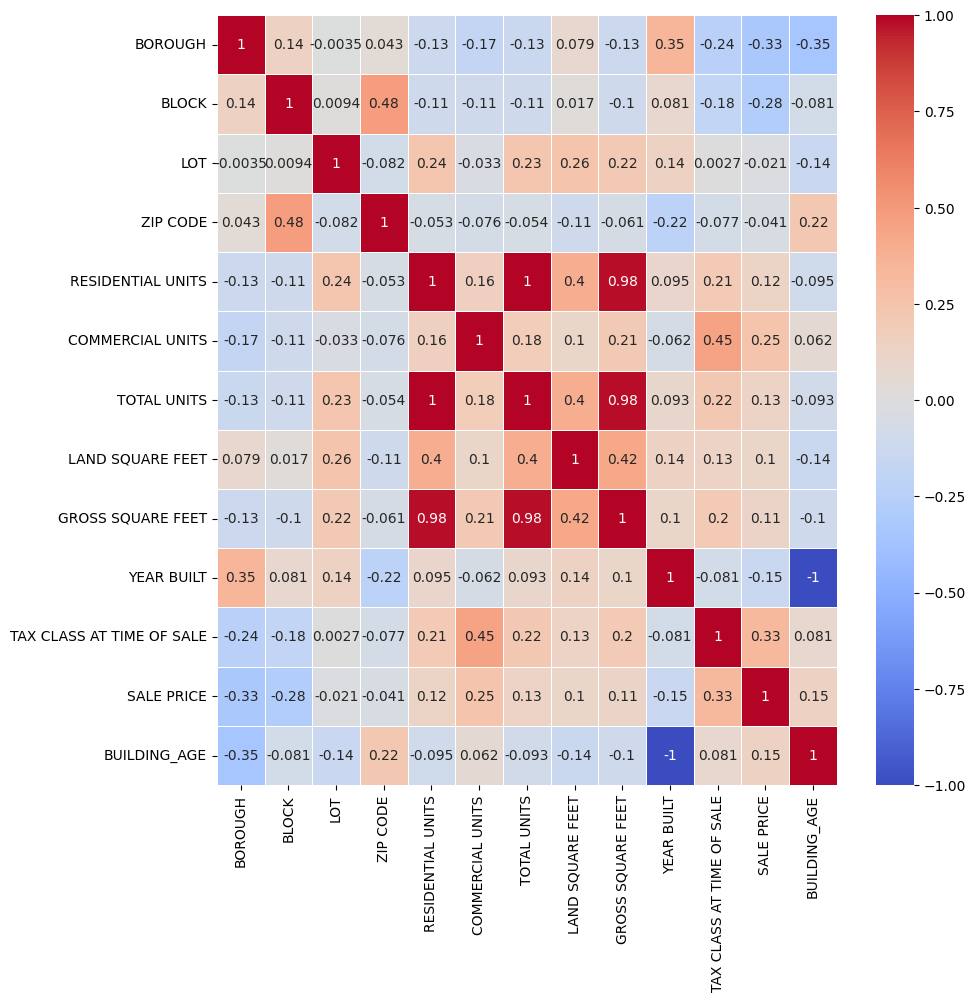

In [242]:
# Create correlation matrix
# Drop non-numeric columns for correlation calculation
df_numeric = df.drop(columns=['BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT'])
corr_matrix = df_numeric.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix,cmap="coolwarm", annot=True, linewidths=.5, ax = ax)

In [243]:
# removing highly correlated indepdent varaible from the dataset
df.drop(['RESIDENTIAL UNITS','GROSS SQUARE FEET','YEAR BUILT', 'TAX CLASS AT PRESENT'],inplace=True, axis=1)
df.head()

,BOROUGH,BUILDING CLASS CATEGORY,BLOCK,LOT,ZIP CODE,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,TAX CLASS AT TIME OF SALE,SALE PRICE,BUILDING_AGE
3,1,07 RENTALS - WALKUP APARTMENTS,376,41,10009.0,0.0,28.0,4542.0,2,540000,125.0
7,1,07 RENTALS - WALKUP APARTMENTS,400,11,10009.0,0.0,18.0,2404.0,2,280000,125.0
8,1,07 RENTALS - WALKUP APARTMENTS,400,54,10009.0,3.0,11.0,2364.0,2,8800000,125.0
9,1,07 RENTALS - WALKUP APARTMENTS,402,36,10009.0,2.0,10.0,1919.0,2,2000000,125.0
11,1,07 RENTALS - WALKUP APARTMENTS,404,42,10009.0,0.0,10.0,2369.0,2,4000000,125.0


In [244]:
df.nunique()

,0
BOROUGH,5
BUILDING CLASS CATEGORY,17
BLOCK,8694
LOT,609
ZIP CODE,172
COMMERCIAL UNITS,12
TOTAL UNITS,92
LAND SQUARE FEET,3508
TAX CLASS AT TIME OF SALE,3
SALE PRICE,3500


In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20139 entries, 3 to 79329
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BOROUGH                    20139 non-null  int64  
 1   BUILDING CLASS CATEGORY    20139 non-null  object 
 2   BLOCK                      20139 non-null  int64  
 3   LOT                        20139 non-null  int64  
 4   ZIP CODE                   20139 non-null  float64
 5   COMMERCIAL UNITS           20139 non-null  float64
 6   TOTAL UNITS                20139 non-null  float64
 7   LAND SQUARE FEET           20139 non-null  float64
 8   TAX CLASS AT TIME OF SALE  20139 non-null  int64  
 9   SALE PRICE                 20139 non-null  int64  
 10  BUILDING_AGE               20139 non-null  float64
dtypes: float64(5), int64(5), object(1)
memory usage: 1.8+ MB


In [246]:
df = pd.get_dummies(df, columns=['BUILDING CLASS CATEGORY'], drop_first=True)
df.head()

,BOROUGH,BLOCK,LOT,ZIP CODE,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,TAX CLASS AT TIME OF SALE,SALE PRICE,BUILDING_AGE,...,BUILDING CLASS CATEGORY_21 OFFICE BUILDINGS,BUILDING CLASS CATEGORY_22 STORE BUILDINGS,BUILDING CLASS CATEGORY_25 LUXURY HOTELS,BUILDING CLASS CATEGORY_26 OTHER HOTELS,BUILDING CLASS CATEGORY_27 FACTORIES,BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES,BUILDING CLASS CATEGORY_30 WAREHOUSES,BUILDING CLASS CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING CLASS CATEGORY_37 RELIGIOUS FACILITIES,BUILDING CLASS CATEGORY_38 ASYLUMS AND HOMES
3,1,376,41,10009.0,0.0,28.0,4542.0,2,540000,125.0,...,False,False,False,False,False,False,False,False,False,False
7,1,400,11,10009.0,0.0,18.0,2404.0,2,280000,125.0,...,False,False,False,False,False,False,False,False,False,False
8,1,400,54,10009.0,3.0,11.0,2364.0,2,8800000,125.0,...,False,False,False,False,False,False,False,False,False,False
9,1,402,36,10009.0,2.0,10.0,1919.0,2,2000000,125.0,...,False,False,False,False,False,False,False,False,False,False
11,1,404,42,10009.0,0.0,10.0,2369.0,2,4000000,125.0,...,False,False,False,False,False,False,False,False,False,False


## Phase 2 — Baseline modeling

Goal it so see if dataset even has any predictive power.

In [247]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

In [248]:
# Select features + target (log1p for stability)
target_col = "SALE PRICE"

model_df = df.copy()

X = model_df.drop(['SALE PRICE'],axis = 1).values
y = np.log1p(model_df[target_col].astype(float).values)

print("Rows for modeling:", len(model_df))
print("y (log1p) range:", float(y.min()), "to", float(y.max()))

Rows for modeling: 20139
y (log1p) range: 11.51293546492023 to 16.118095750958314


In [249]:
# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", len(X_train), "Test:", len(X_test))

Train: 16111 Test: 4028


In [250]:
# Preprocess: scale all numeric features using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_p = scaler.fit_transform(X_train)
X_test_p  = scaler.transform(X_test)

print("Processed shapes:", X_train_p.shape, X_test_p.shape)

Processed shapes: (16111, 25) (4028, 25)


In [251]:
# Baseline model (strong + fast): Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

lin_reg = LinearRegression()
lin_reg.fit(X_train_p, y_train)

y_pred = lin_reg.predict(X_test_p)

print("Baseline (Linear Regression) on log1p(price):")
print(f"  R2:  {r2_score(y_test, y_pred):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"  RMSE:{np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Also report dollars for interpretability
y_pred_dollars = np.expm1(y_pred)
y_test_dollars = np.expm1(y_test)

print("\nBaseline (Linear Regression) in dollars:")
print(f"  MAE:  ${mean_absolute_error(y_test_dollars, y_pred_dollars):,.0f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test_dollars, y_pred_dollars)):,.0f}")

Baseline (Linear Regression) on log1p(price):
  R2:  0.2758
  MAE: 0.3635
  RMSE:0.5166

Baseline (Linear Regression) in dollars:
  MAE:  $494,697
  RMSE: $1,065,239


In [252]:
# RandomForest Regressor model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train_p, y_train)

y_pred = rfr.predict(X_test_p)

print("RandomForest Regressor on log1p(price):")
print(f"  R2:  {r2_score(y_test, y_pred):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"  RMSE:{np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Also report dollars for interpretability
y_pred_dollars = np.expm1(y_pred)
y_test_dollars = np.expm1(y_test)

print("\nRandomForest Regressor in dollars:")
print(f"  MAE:  ${mean_absolute_error(y_test_dollars, y_pred_dollars):,.0f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test_dollars, y_pred_dollars)):,.0f}")

RandomForest Regressor on log1p(price):
  R2:  0.5677
  MAE: 0.2685
  RMSE:0.3991

RandomForest Regressor in dollars:
  MAE:  $345,687
  RMSE: $716,078


### Base NN

In [253]:
X_train_nn = X_train_p.astype(np.float32)
X_test_nn  = X_test_p.astype(np.float32)

y_train_nn = y_train.astype(np.float32)
y_test_nn  = y_test.astype(np.float32)

print(X_train_nn.shape, X_test_nn.shape, y_train_nn.shape, y_test_nn.shape)

(16111, 25) (4028, 25) (16111,) (4028,)


In [254]:
# creating baseline NN model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()

baseline_nn = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_nn.shape[1],)),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(1)  # predicts y in log1p space
])

baseline_nn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
)

baseline_nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,649 (45.50 KB)

 Trainable params: 11,649 (45.50 KB)

 Non-trainable params: 0 (0.00 B)

In [255]:
history_base = baseline_nn.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 90.8313 - mae: 8.0970 - val_loss: 4.3658 - val_mae: 1.1186
Epoch 2/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.9818 - mae: 1.8279 - val_loss: 1.3476 - val_mae: 0.7619
Epoch 3/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9699 - mae: 1.5894 - val_loss: 0.6501 - val_mae: 0.5664
Epoch 4/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6507 - mae: 1.4799 - val_loss: 0.5374 - val_mae: 0.5387
Epoch 5/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5471 - mae: 1.4139 - val_loss: 0.4113 - val_mae: 0.4739
Epoch 6/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0014 - mae: 1.3437 - val_loss: 0.3898 - val_mae: 0.4581
Epoch 7/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0134 - mae: 1.3333 - val_loss: 0.3904 - val_mae: 0.4272
Epoch 8/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6522 - mae: 1.2807 - val_loss: 0.4456 - val_mae: 0.4801
Epoch 9/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

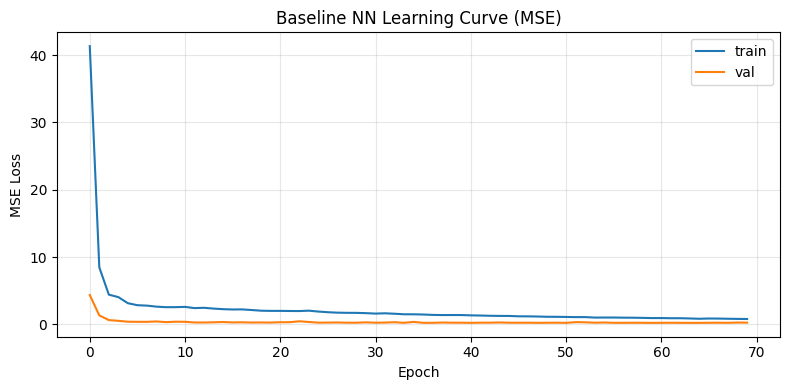

In [256]:
# Loss curved
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history_base.history["loss"], label="train")
plt.plot(history_base.history["val_loss"], label="val")
plt.title("Baseline NN Learning Curve (MSE)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [257]:
# Evaluate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_pred_log = baseline_nn.predict(X_test_nn).flatten()

print("Baseline NN on log1p(price):")
print(f"  R2:   {r2_score(y_test_nn, y_pred_log):.4f}")
print(f"  MAE:  {mean_absolute_error(y_test_nn, y_pred_log):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_nn, y_pred_log)):.4f}")

# dollars (since your y is log1p)
y_pred_dollars = np.expm1(y_pred_log)
y_test_dollars = np.expm1(y_test_nn)

print("\nBaseline NN in dollars:")
print(f"  MAE:  ${mean_absolute_error(y_test_dollars, y_pred_dollars):,.0f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test_dollars, y_pred_dollars)):,.0f}")

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Baseline NN on log1p(price):
  R2:   0.4182
  MAE:  0.3240
  RMSE: 0.4630

Baseline NN in dollars:
  MAE:  $440,183
  RMSE: $902,501


In [264]:
abs_err = np.abs(y_test_dollars - y_pred_dollars)

idx_best = np.argsort(abs_err)[:10]
idx_worst = np.argsort(abs_err)[-10:]

print("Top 10 best successes (lowest absolute $ error):")
display(pd.DataFrame({
    "true_price": y_test_dollars[idx_best],
    "pred_price": y_pred_dollars[idx_best],
    "abs_error": abs_err[idx_best],
}).sort_values("abs_error"))

print("\nTop 10 biggest misses (highest absolute $ error):")
display(pd.DataFrame({
    "true_price": y_test_dollars[idx_worst],
    "pred_price": y_pred_dollars[idx_worst],
    "abs_error": abs_err[idx_worst],
}).sort_values("abs_error", ascending=False))

Top 10 best successes (lowest absolute $ error):


,true_price,pred_price,abs_error
0,5.819998e+05,5.819438e+05,56.0625
1,7.699998e+05,7.702157e+05,215.9375
2,6.120002e+05,6.122951e+05,294.8125
3,9.800002e+05,9.797040e+05,296.1875
4,9.320004e+05,9.316111e+05,389.2500
5,7.245000e+05,7.240849e+05,415.1250
6,6.699999e+05,6.695719e+05,428.0000
7,1.240000e+06,1.240559e+06,559.5000
8,6.749998e+05,6.744258e+05,573.9375
9,1.225000e+06,1.225851e+06,850.7500



Top 10 biggest misses (highest absolute $ error):


,true_price,pred_price,abs_error
9,9999996.0,2544669.500,7455326.5
8,9600005.0,2186025.750,7413979.0
7,8949998.0,1572362.250,7377636.0
6,9294073.0,2097034.125,7197039.0
5,8750004.0,1633610.875,7116393.0
4,9000001.0,2043630.875,6956370.0
3,8500000.0,1658184.875,6841815.0
2,8750004.0,1919097.750,6830906.0
1,9400006.0,2809066.000,6590940.0
0,9999996.0,3438295.000,6561701.0


## Phase 3 — Two-Headed Model (Aleatoric + Epistemic)

Architecture: shared Dense layers with Dropout (MC Dropout), two heads for mean (μ) and log-variance (σ²). Loss: Gaussian NLL. Target: log(SALE PRICE) for heteroscedastic NYC prices.

In [259]:
# Create y_train_raw/y_test_raw and MinMax-scale targets (prof style)
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Your y_train/y_test are log1p(price). Convert back to dollars.
y_train_raw = np.expm1(y_train).astype(np.float32)
y_test_raw  = np.expm1(y_test).astype(np.float32)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).astype(np.float32)
y_test_scaled  = scaler_y.transform(y_test_raw.reshape(-1, 1)).astype(np.float32)

y_range = float(scaler_y.data_range_[0])  # dollars range for variance scaling

print("y_train_raw range ($):", float(y_train_raw.min()), "to", float(y_train_raw.max()))
print("y_train_scaled range:", float(y_train_scaled.min()), "to", float(y_train_scaled.max()))
print("y_range ($):", y_range)

y_train_raw range ($): 100000.0 to 10000000.0
y_train_scaled range: 0.0 to 0.9999999403953552
y_range ($): 9900000.0


In [260]:
# Two-headed model + aleatoric NLL (copy professor, same sizes)
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()
set_seeds(42)

def aleatoric_loss(y_true, y_pred):
    mu = y_pred[:, 0:1]
    sigma_sq = y_pred[:, 1:2]
    eps = 1e-6
    return tf.reduce_mean(
        0.5 * tf.math.log(sigma_sq + eps) +
        0.5 * tf.square(y_true - mu) / (sigma_sq + eps)
    )

def make_combined_model(n_features, dropout_rate=0.2):
    inputs = Input(shape=(n_features,))
    x = Dense(128, activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x, training=True)  # keep ON for MC-dropout

    x = Dense(64, activation="relu")(x)
    x = BatchNormalization()(x)

    mu = Dense(1, name="mu")(x)
    sigma_sq = Dense(1, activation="softplus", name="sigma_sq")(x)
    return tf.keras.Model(inputs=inputs, outputs=Concatenate()([mu, sigma_sq]))

model_uq = make_combined_model(X_train_p.shape[1], dropout_rate=0.2)
model_uq.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=aleatoric_loss)
model_uq.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      3,328 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigma_sq (Dense)    │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2)         │          0 │ mu[0][0],         │
│ (Concatenate)       │                   │            │ sigma_sq[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,482 (48.76 KB)

 Trainable params: 12,098 (47.26 KB)

 Non-trainable params: 384 (1.50 KB)

In [261]:
# Train
history_uq = model_uq.fit(
    X_train_p.astype(np.float32),
    y_train_scaled,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
    verbose=1
)

Epoch 1/300
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4347 - val_loss: -0.4564
Epoch 2/300
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -0.7337 - val_loss: -1.4307
Epoch 3/300
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -1.4590 - val_loss: -1.8646
Epoch 4/300
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -1.8392 - val_loss: -2.1326
Epoch 5/300
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -2.0398 - val_loss: -2.2588
Epoch 6/300
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -2.2438 - val_loss: -2.3820
Epoch 7/300
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -2.3482 - val_loss: -2.3758
Epoch 8/300
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -2.3530 - val_loss: -2.4131
Epoch 9/300
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: -2.3844 - val_loss: -2.4572
Epoch 10/300
403/403 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: -2.4350 - val_loss: -2.4768
Epoch 11/300
403/403 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: -2.4610 - val_loss: -2.4700
Epoch 12/300
403/403

In [262]:
# MC inference + reverse scaling

import numpy as np

T = 100

preds = np.stack([model_uq(X_test_p.astype(np.float32), training=True).numpy() for _ in range(T)], axis=0)
# preds shape: [T, N, 2]

# epistemic: mu spread across MC runs
mu_scaled = preds[:, :, 0]  # [T,N]
all_mu_dollars = scaler_y.inverse_transform(mu_scaled.reshape(-1, 1)).reshape(T, -1)

# aleatoric: predicted sigma_sq is in scaled-space variance -> convert to $^2
sigma_sq_scaled = preds[:, :, 1]  # [T,N]
all_sigma_sq_dollars = sigma_sq_scaled * (y_range ** 2)

final_mean = all_mu_dollars.mean(axis=0)  # [N]
total_std  = np.sqrt(all_mu_dollars.var(axis=0) + all_sigma_sq_dollars.mean(axis=0))  # [N]

print("final_mean ($) stats:", float(final_mean.min()), float(final_mean.mean()), float(final_mean.max()))
print("total_std ($) stats:", float(total_std.min()), float(total_std.mean()), float(total_std.max()))

final_mean ($) stats: -299209.1875 1228602.25 11926255.0
total_std ($) stats: 161777.625 652688.125 46953868.0


In [263]:
# Metrics (R² + MAE in dollars)
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(y_test_raw, final_mean)
mae = mean_absolute_error(y_test_raw, final_mean)

print(f"Two-headed UQ model (dollars):")
print(f"  R2:  {r2:.4f}")
print(f"  MAE: ${mae:,.0f}")

Two-headed UQ model (dollars):
  R2:  0.3119
  MAE: $459,546


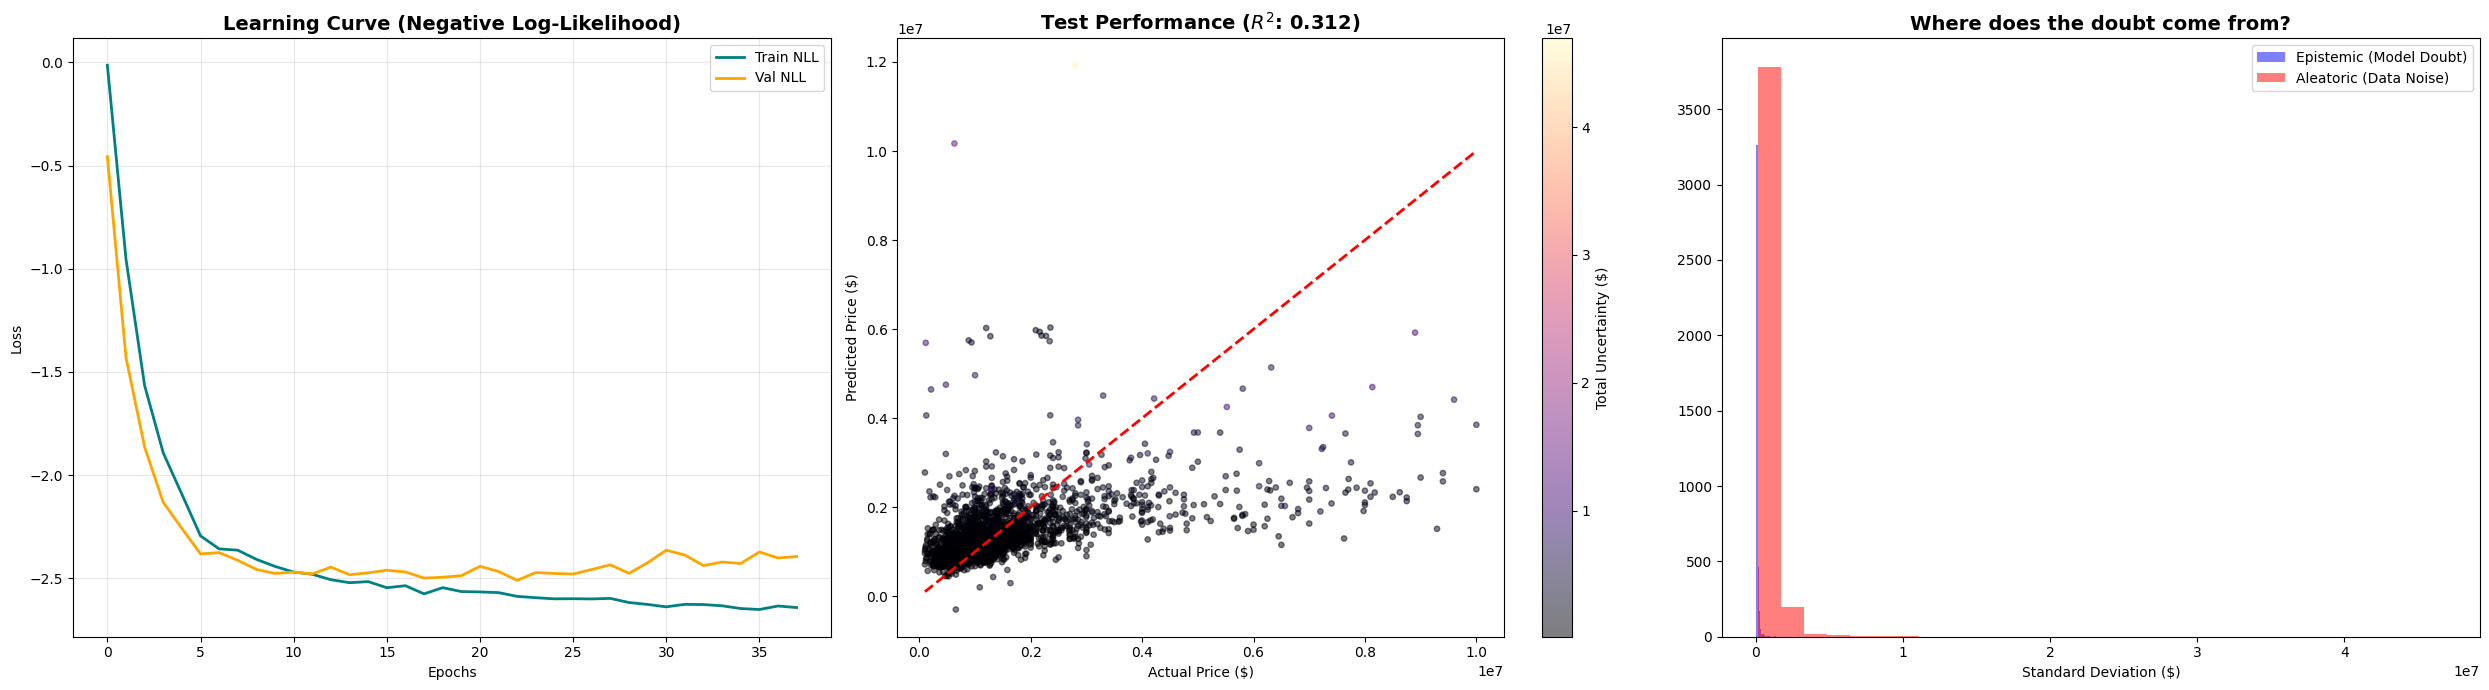

In [266]:
# --- 5. VISUALIZATION: NOW WITH LEARNING CURVE ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7))

# Plot A: Learning Curve
ax1.plot(history_uq.history['loss'], label='Train NLL', color='teal', lw=2)
ax1.plot(history_uq.history['val_loss'], label='Val NLL', color='orange', lw=2)
ax1.set_title("Learning Curve (Negative Log-Likelihood)", fontsize=14, fontweight='bold')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(alpha=0.3)

# Plot B: Scatter Performance
r2 = r2_score(y_test_raw, final_mean)
sc = ax2.scatter(y_test_raw, final_mean, c=total_std, cmap='magma', alpha=0.5, s=15)
ax2.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], 'r--', lw=2)
fig.colorbar(sc, ax=ax2, label="Total Uncertainty ($)")
ax2.set_title(f"Test Performance ($R^2$: {r2:.3f})", fontsize=14, fontweight='bold')
ax2.set_xlabel("Actual Price ($)")
ax2.set_ylabel("Predicted Price ($)")

# Plot C: Uncertainty Decomposition
ax3.hist(np.sqrt(all_mu_dollars.var(axis=0)), bins=30, alpha=0.5, label='Epistemic (Model Doubt)', color='blue')
ax3.hist(np.sqrt(all_sigma_sq_dollars.mean(axis=0)), bins=30, alpha=0.5, label='Aleatoric (Data Noise)', color='red')
ax3.set_title("Where does the doubt come from?", fontsize=14, fontweight='bold')
ax3.set_xlabel("Standard Deviation ($)")
ax3.legend()

plt.tight_layout()
plt.show()

## Phase 4 — Uncertainty & SHAP Analysis

Compute epistemic (MC Dropout) and aleatoric (learned variance) uncertainty, interval coverage, and outlier inspection.

## 🔴 Gaussian

In [267]:
# Create a mask of (100 passes, 3400 houses)
# Each pass has its own mu and its own sigma_sq
mu_samples = all_mu_dollars # Shape (100, 3400)
sigma_samples = np.sqrt(all_sigma_sq_dollars) # Shape (100, 3400)

# For every single pass, did THAT specific 'brain' capture the truth?
# We use the Gaussian bound for EACH pass
individual_hit_mask = (y_test_raw >= mu_samples - 1.96 * sigma_samples) & \
                      (y_test_raw <= mu_samples + 1.96 * sigma_samples)

# Now we calculate the hit rate PER HOUSE (Mean across the 100 passes)
house_hit_rates = np.mean(individual_hit_mask, axis=0) # Shape (3400,)

print(f"Shape of Hit Rates: {house_hit_rates.shape}")
print(f"Average hit rate across all houses: {np.mean(house_hit_rates):.2%}")

Shape of Hit Rates: (4028,)
Average hit rate across all houses: 94.61%


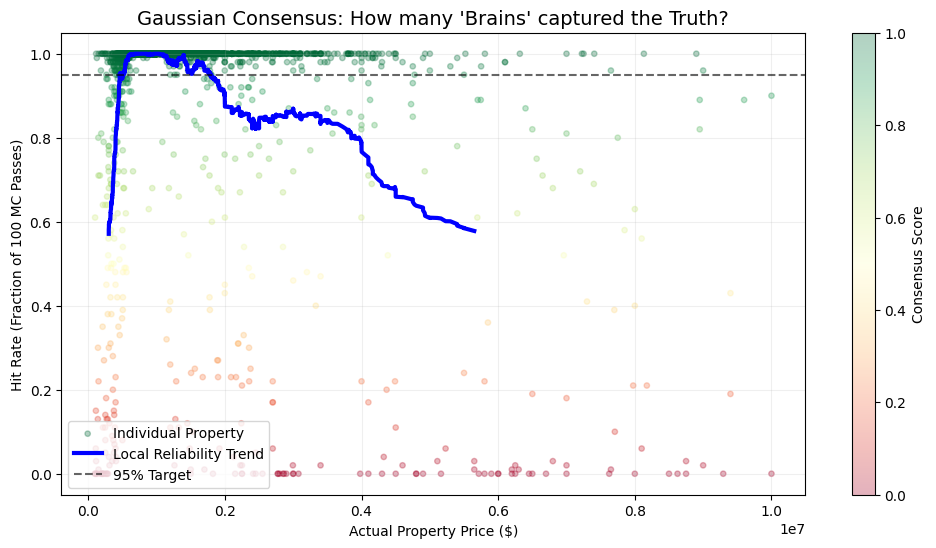

In [269]:
import pandas as pd

# 1. 'house_hit_rates' is our Y-axis (from your code)
# 2. 'y_test_raw' is our X-axis

plt.figure(figsize=(12, 6))

# Scatter plot: color points by their hit rate (Green = High Consensus, Red = Disagreement)
plt.scatter(y_test_raw, house_hit_rates, alpha=0.3,
            c=house_hit_rates, cmap='RdYlGn', s=15, label='Individual Property')

# 3. Add a Rolling Mean to show "Reliability Zones"
# This helps students see if the model fails more on expensive vs. cheap houses
df_trend = pd.DataFrame({'price': y_test_raw, 'hit_rate': house_hit_rates}).sort_values('price')
df_trend['rolling_avg'] = df_trend['hit_rate'].rolling(window=150, center=True).mean()

plt.plot(df_trend['price'], df_trend['rolling_avg'], color='blue', lw=3, label='Local Reliability Trend')

# 4. Target Line (The 95% Promise)
plt.axhline(0.95, color='black', linestyle='--', alpha=0.6, label='95% Target')

plt.title("Gaussian Consensus: How many 'Brains' captured the Truth?", fontsize=14)
plt.xlabel("Actual Property Price ($)")
plt.ylabel("Hit Rate (Fraction of 100 MC Passes)")
plt.ylim(-0.05, 1.05)
plt.colorbar(label="Consensus Score")
plt.legend(loc='lower left')
plt.grid(alpha=0.2)
plt.show()

## 🔴 Empirical

In [270]:
# --- 1. EXTRACT & SCALE THE BRAINS ---
# Extract mu and sigma_sq from your 'preds' cube
# preds shape is (T, N, 2)
mu_samples_scaled = preds[:, :, 0]
sigma_sq_samples_scaled = preds[:, :, 1]

# Convert mu samples to Dollars
mu_samples = scaler_y.inverse_transform(mu_samples_scaled.reshape(-1, 1)).reshape(T, -1)

# Convert sigma_sq to Dollar variance
sigma_sq_samples = sigma_sq_samples_scaled * (y_range**2)

# --- 2. GENERATE THE SAMPLES (T=100, N=3400) ---
# Now that we have dollar-scale mu and sigma_sq, this won't crash!
full_samples = np.random.normal(loc=mu_samples, scale=np.sqrt(sigma_sq_samples))

# --- 3. CALCULATE POINT-WISE EMPIRICAL BOUNDS ---
emp_lower = np.percentile(full_samples, 2.5, axis=0)
emp_upper = np.percentile(full_samples, 97.5, axis=0)

# --- 4. POINT-WISE TRUTH TEST ---
# Ensure y_test_raw is in dollars
emp_hit_mask = (y_test_raw >= emp_lower) & (y_test_raw <= emp_upper)
emp_coverage = np.mean(emp_hit_mask)

print(f"✅ Empirical 95% Coverage: {emp_coverage:.2%}")

if emp_coverage < 0.90:
    print("⚠️ ALERT: Coverage is low. The model is overconfident (underestimating noise).")
else:
    print("🎯 Target Hit: The model's uncertainty captures reality.")

✅ Empirical 95% Coverage: 94.54%
🎯 Target Hit: The model's uncertainty captures reality.


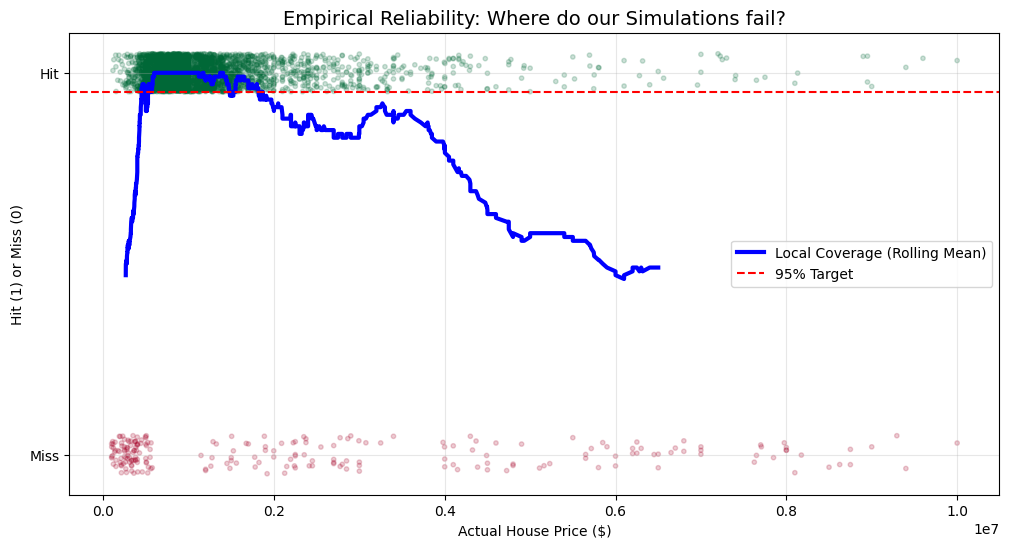

In [271]:
# 1. Ensure we are using the Empirical Hit Mask (True/False for each house)
# This is based on the 2.5th and 97.5th percentiles of the 100 simulations
emp_hits = emp_hit_mask.astype(int)

plt.figure(figsize=(12, 6))

# We use a scatter plot with a bit of 'jitter' on the Y-axis
# so you can see the density of the hits vs misses
jitter = np.random.uniform(-0.05, 0.05, size=len(emp_hits))

plt.scatter(y_test_raw, emp_hits + jitter, alpha=0.2,
            c=emp_hits, cmap='RdYlGn', s=10)

# Add a rolling mean to show the 'Local Coverage' across price ranges
import pandas as pd
df_reliability = pd.DataFrame({'price': y_test_raw, 'hit': emp_hits}).sort_values('price')
df_reliability['rolling_coverage'] = df_reliability['hit'].rolling(window=100, center=True).mean()

plt.plot(df_reliability['price'], df_reliability['rolling_coverage'],
         color='blue', lw=3, label='Local Coverage (Rolling Mean)')

plt.axhline(0.95, color='red', linestyle='--', label='95% Target')

plt.title("Empirical Reliability: Where do our Simulations fail?", fontsize=14)
plt.xlabel("Actual House Price ($)")
plt.ylabel("Hit (1) or Miss (0)")
plt.yticks([0, 1], ["Miss", "Hit"])
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 🔵 SHAP
To update SHAP for the dual-headed model, we are going to create two explainers.

The first explains the Price (Mean), and the others explain the Uncertainty (Total Standard Deviation)

In [272]:
# --- 1. REPAIRED DOLLAR PREDICTORS (Synced with your Scaler) ---

def predict_mean_final(x_np):
    # Ensure it's a tensor for the model
    preds = model(x_np, training=False)
    # Extract Mu (index 0)
    mu_scaled = preds[0].numpy() if isinstance(preds, list) else preds.numpy()[:, 0]
    # Use your ACTUAL scaler to be safe
    return scaler_y.inverse_transform(mu_scaled.reshape(-1, 1)).flatten()

def predict_epistemic_final(x_np):
    # 50 brains to find disagreement
    preds = np.stack([model(x_np, training=True) for _ in range(50)])
    mu_samples = preds[:, 0, :, 0] if isinstance(preds[0], list) else preds[:, :, 0]

    # Transform all samples to dollar space first
    all_mu_dollars = np.stack([
        scaler_y.inverse_transform(mu_samples[i].reshape(-1, 1)).flatten()
        for i in range(50)
    ])
    return all_mu_dollars.std(axis=0)

def predict_aleatoric_final(x_np):
    # Get the model output (Mean and Sigma_sq)
    preds = model(x_np, training=False)

    # Extract the sigma_sq head (index 1)
    # Handle list output for multi-head models or array output for single-head
    sigma_sq_scaled = preds[1].numpy() if isinstance(preds, list) else preds.numpy()[:, 1]

    # Conversion: Sigma_sq is variance in scaled space.
    # To get Dollars, we multiply by (y_range^2) and then take the square root.
    sigma_sq_dollars = sigma_sq_scaled.flatten() * (y_range**2)
    return np.sqrt(sigma_sq_dollars)

# --- 1. SET THE STAGE ---
X_subset = X_test[:40]

# --- UPDATED DICTIONARY ---
surgical_predictors = {
    "Price (Mean)": predict_mean_final,
    "Model Doubt (Epistemic)": predict_epistemic_final,
    "Data Noise (Aleatoric)": predict_aleatoric_final
}

# --- 2. CORRECTED PULSE CHECK (No .values error) ---
# X_subset is a numpy array, so we pass it directly
test_prices = predict_mean_final(X_subset)

print("--- 10-SECOND PULSE CHECK ---")
print(f"Sample Price 1: ${test_prices[0]:,.2f}")
print(f"Sample Price 2: ${test_prices[1]:,.2f}")
print(f"Standard Dev:    {test_prices.std():.4f}")

if test_prices.std() < 1:
    print("🚨 ALERT: Still no variance. Check if model.predict(X_subset) returns different values!")

NameError: name 'model' is not defined